In [1]:
from ast import literal_eval
from pandas import DataFrame  # http://github.com/pydata/pandas
import pandas as pd
import re
import requests               # http://github.com/kennethreitz/requests
import subprocess
import sys
import json
import glob
from os import path
import itertools

In [2]:
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
%matplotlib inline

In [3]:
corpora = dict(eng_us_2012=17, eng_us_2009=5, eng_gb_2012=18, eng_gb_2009=6,
               chi_sim_2012=23, chi_sim_2009=11, eng_2012=15, eng_2009=0,
               eng_fiction_2012=16, eng_fiction_2009=4, eng_1m_2009=1,
               fre_2012=19, fre_2009=7, ger_2012=20, ger_2009=8, heb_2012=24,
               heb_2009=9, spa_2012=21, spa_2009=10, rus_2012=25, rus_2009=12,
               ita_2012=22)

In [4]:
def getNgrams(query, corpus, startYear, endYear, smoothing, caseInsensitive):
    params = dict(content=query, year_start=startYear, year_end=endYear,
                  corpus=corpora[corpus], smoothing=smoothing,
                  case_insensitive=caseInsensitive)
    if params['case_insensitive'] is False:
        params.pop('case_insensitive')
    if '?' in params['content']:
        params['content'] = params['content'].replace('?', '*')
    if '@' in params['content']:
        params['content'] = params['content'].replace('@', '=>')
    req = requests.get('http://books.google.com/ngrams/graph', params=params)
    res = re.findall('var data = (.*?);\\n', req.text)
    if res:
        data = {qry['ngram']: qry['timeseries']
                for qry in literal_eval(res[0])}
        df = DataFrame(data)
        df.insert(0, 'year', list(range(startYear, startYear+len(df))))
        df.set_index('year', inplace=True)
        df = df[list(filter(lambda x:"(All)" in x, df.columns))]
        df = df.rename(columns={x:x.split("(All)")[0] for x in df.columns})
    else:
        df = DataFrame()
    return req.url, params['content'], df

In [5]:
def word_freq(words1):
    q, word, df = getNgrams(words1[0], "eng_2012", 1800, 2015, True, True)

    for word in words1[1:]:
        q, word, df_ = getNgrams(word, "eng_2012", 1800, 2015, True, True)
        df = df.join(df_)
    return df

In [6]:
def load_nyt_json(filename):
    obj = json.load(open(filename))
    words = obj["graph_data"]
    assert len(words) == 1
    only_word = words[0]
    term1 = only_word["term"]
    term2 = path.basename(filename).split(".")[0]
    assert term1 == term2

    df = pd.DataFrame.from_records(only_word["data"])
    df = df.rename(columns={"total_articles_published": "Total", "article_matches": term1})
    database = df[["Total", term1, "year"]]
    return term1, database

def load_nyt_database():
    word, database = load_nyt_json("data/NYT_new/bicultural.json")

    for file in glob.glob("data/NYT_new/*json"):
      word, df = load_nyt_json(file)
      if word == "bicultural": continue
      df.drop("Total", 1, inplace=True)
      df = df.rename(columns={"article_matches": word})
      database = pd.merge(database, df, on="year", how="outer")

    database.set_index("year", inplace=True)
    values = (database.values.T / database.Total.values).T
    values[:, 0] = database.Total.values
    database_norm = pd.DataFrame(data=values, columns=database.columns, index=database.index)
    return database_norm

In [7]:
nyt_norm = load_nyt_database()

In [8]:
markers = ['o', '*', '+', '.', ',']

In [9]:
def plot_both(words):
    marker = itertools.cycle(markers) 
    df1 = word_freq(words) 
    axis_1 = df1.plot(style = {w:"-{}".format(next(marker)) for w in words})
    axis_1.set_ylabel("Google Book Ngrams ($\%$)")
    axis_1.set_xlabel("Year")
    _ = axis_1.legend(loc='upper left', ncol=2)
    axis_1.ticklabel_format(style="sci")
    axis_1.grid(True)

    marker = itertools.cycle(markers) 
    axis_2 = axis_1.twinx()
    axis_2 = nyt_norm[words].plot(ax=axis_2, figsize=(14,6), style={w:"--{}".format(next(marker)) for w in words})
    axis_2.set_ylabel("New York Times ($\%$)")
    axis_2.ticklabel_format(style="sci")
    _ = axis_2.legend(loc='upper right', ncol=2)
# Change the style, Roxanne does not like pretty things!

(1930, 2015)

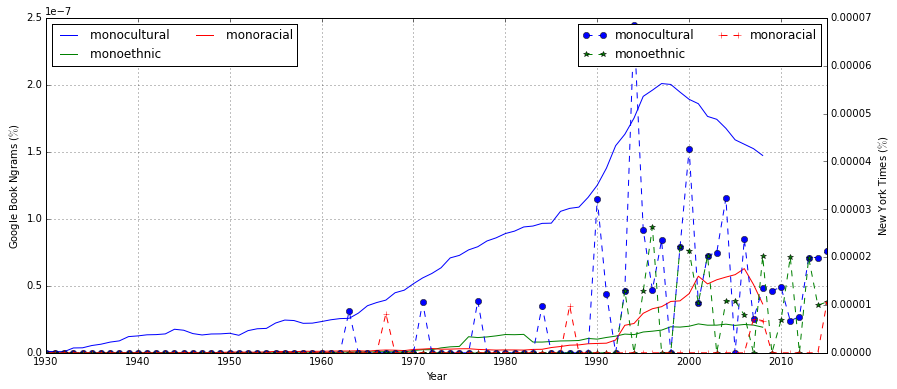

In [23]:
plot_both(['monocultural', 'monoethnic', 'monoracial']) 
plt.xlim(1930, 2015)

1. monoracial has no data from NYT. 
1. 1865, 1905, 1915 (monocultural) NYT

(1910, 2015)

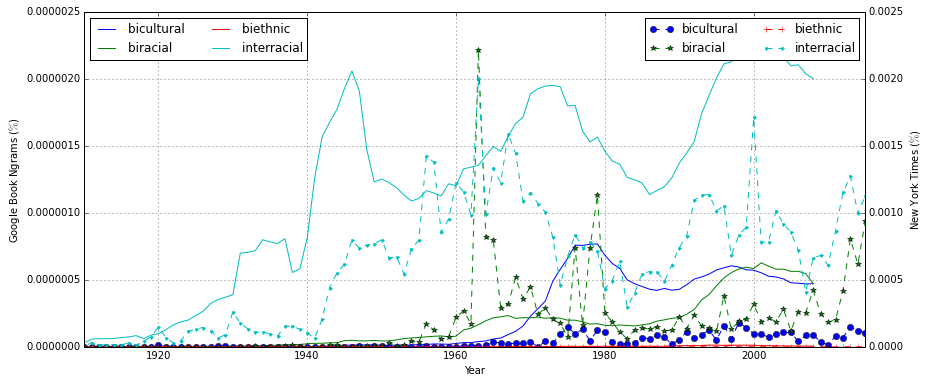

In [27]:
plot_both(['bicultural', 'biracial', 'biethnic', 'interracial'])
plt.xlim(1910, 2015)

1. biethnic has no frequency in NYT
1. 1865 (NYT biracial)

(1950, 2015)

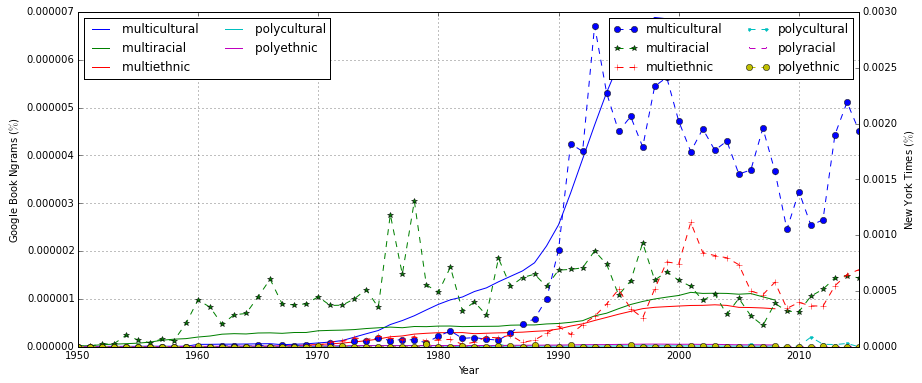

In [14]:
plot_both(['multicultural', 'multiracial', 'multiethnic', 'polycultural', 'polyracial', 'polyethnic'])
plt.xlim(1950, 2015)

1. polyracial and polyethnic have no frequencies in the NYT
1. No data before 1950

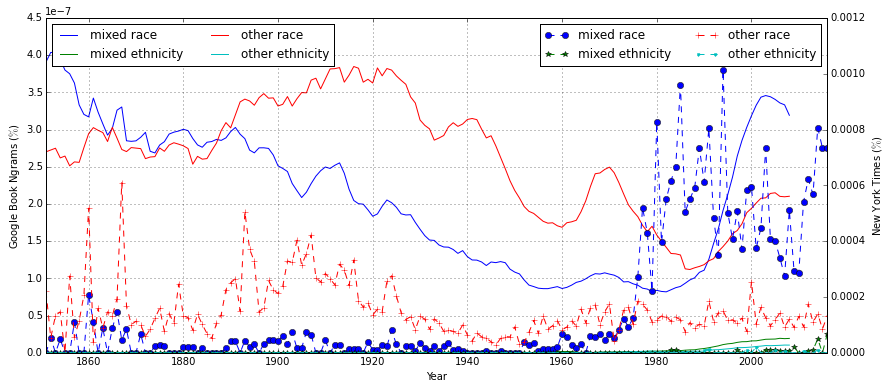

In [15]:
plot_both(['mixed race', 'mixed ethnicity', 'other race', 'other ethnicity'])

1. mixed ethnicity barely has a frequency in the present and other ethnicity has no frequency in the NYT
2. mixed results

(1940, 2015)

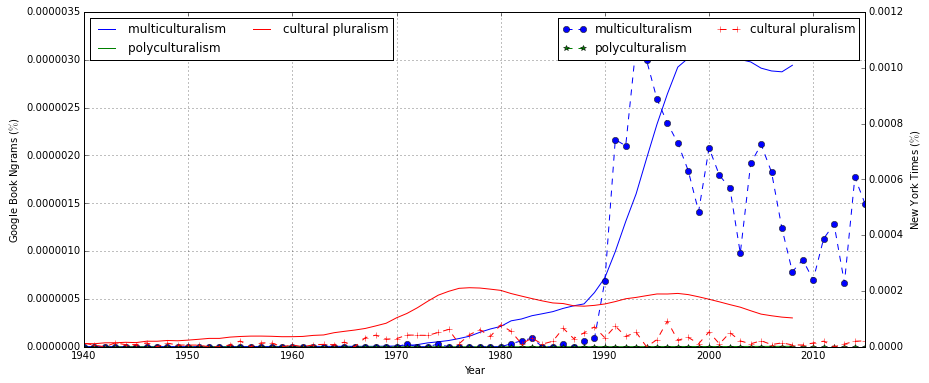

In [17]:
plot_both(['multiculturalism', 'polyculturalism', 'cultural pluralism'])
plt.xlim(1940, 2015)

1. polyculturalism has no frequency in NYT
1. 1865, 1905, 1915, 1925 (cultural pluralism) NYT

(1920, 2015)

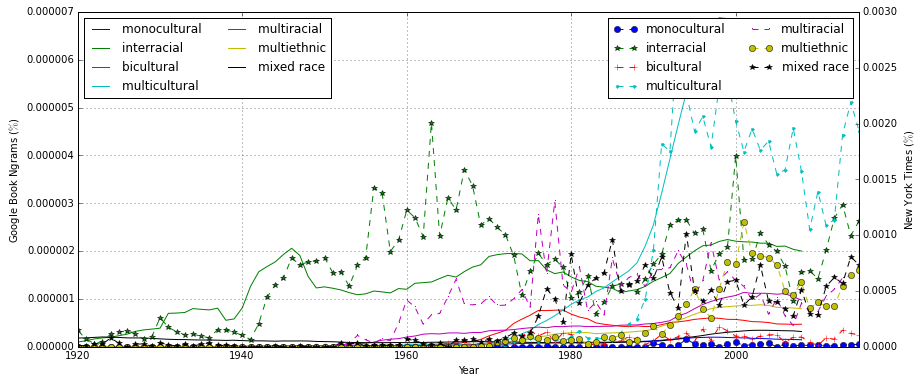

In [22]:
plot_both(['monocultural', 'interracial', 'bicultural', 'multicultural', 'multiracial', 'multiethnic', 'mixed race'])
plt.xlim(1920, 2015)

-Google Book N-Gram: mixed race: 1800 horizontal continuous trend (similar for NYT-- small peak in 1860)

# To Do

1. ~~Check if color is accepted in journals-- may need to switch format of figures (make black and white)~~
1. ~~Use shapes as points and dashed and solid lines to indicate NYT v. Google N-Grams(plot(x,y, ’*’))
s, *, d, h, +, x, p~~
1.~Change Key: Google N-Grams = dashed line, NYT = solid line, shapes for words
1. ~~Need to change word in first graph. --> monocultural and monoracial~~
1. ~~Present data from 1920 onwards and make note about trends previous to this point. ~~
1. Smoothen lines.?